In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpaches
import matplotlib as mpl
import backtrader as bt 
import yfinance as yf





from datetime import datetime

In [2]:
stock = 'BA'
startdate = '2021-08-10'
enddate = '2022-08-11'


df = yf.download(stock,start=startdate, end=enddate,progress=False)
ba = yf.download(stock,start=startdate, end=enddate,progress=False)
df.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-09,229.000000,233.570007,226.889999,232.270004,232.270004,8358600
2021-08-10,231.970001,236.850006,231.619995,235.779999,235.779999,9603500
2021-08-11,236.610001,239.589996,234.580002,239.490005,239.490005,9664000
2021-08-12,240.000000,241.149994,236.509995,238.179993,238.179993,6810000
2021-08-13,238.009995,239.690002,234.279999,234.460007,234.460007,6390300


In [3]:
df = df.loc[:,['Adj Close']]
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)# inplace meaning
df['simple_rtn']=df.adj_close.pct_change()# meaning 
df['log_rtn']=np.log(df.adj_close/df.adj_close.shift(1))


In [4]:
df.head()

,adj_close,simple_rtn,log_rtn
Date,,,
2021-08-09,232.270004,NaN,NaN
2021-08-10,235.779999,0.015112,0.014999
2021-08-11,239.490005,0.015735,0.015613
2021-08-12,238.179993,-0.005470,-0.005485
2021-08-13,234.460007,-0.015618,-0.015742


Text(0.5, 0, 'Date')

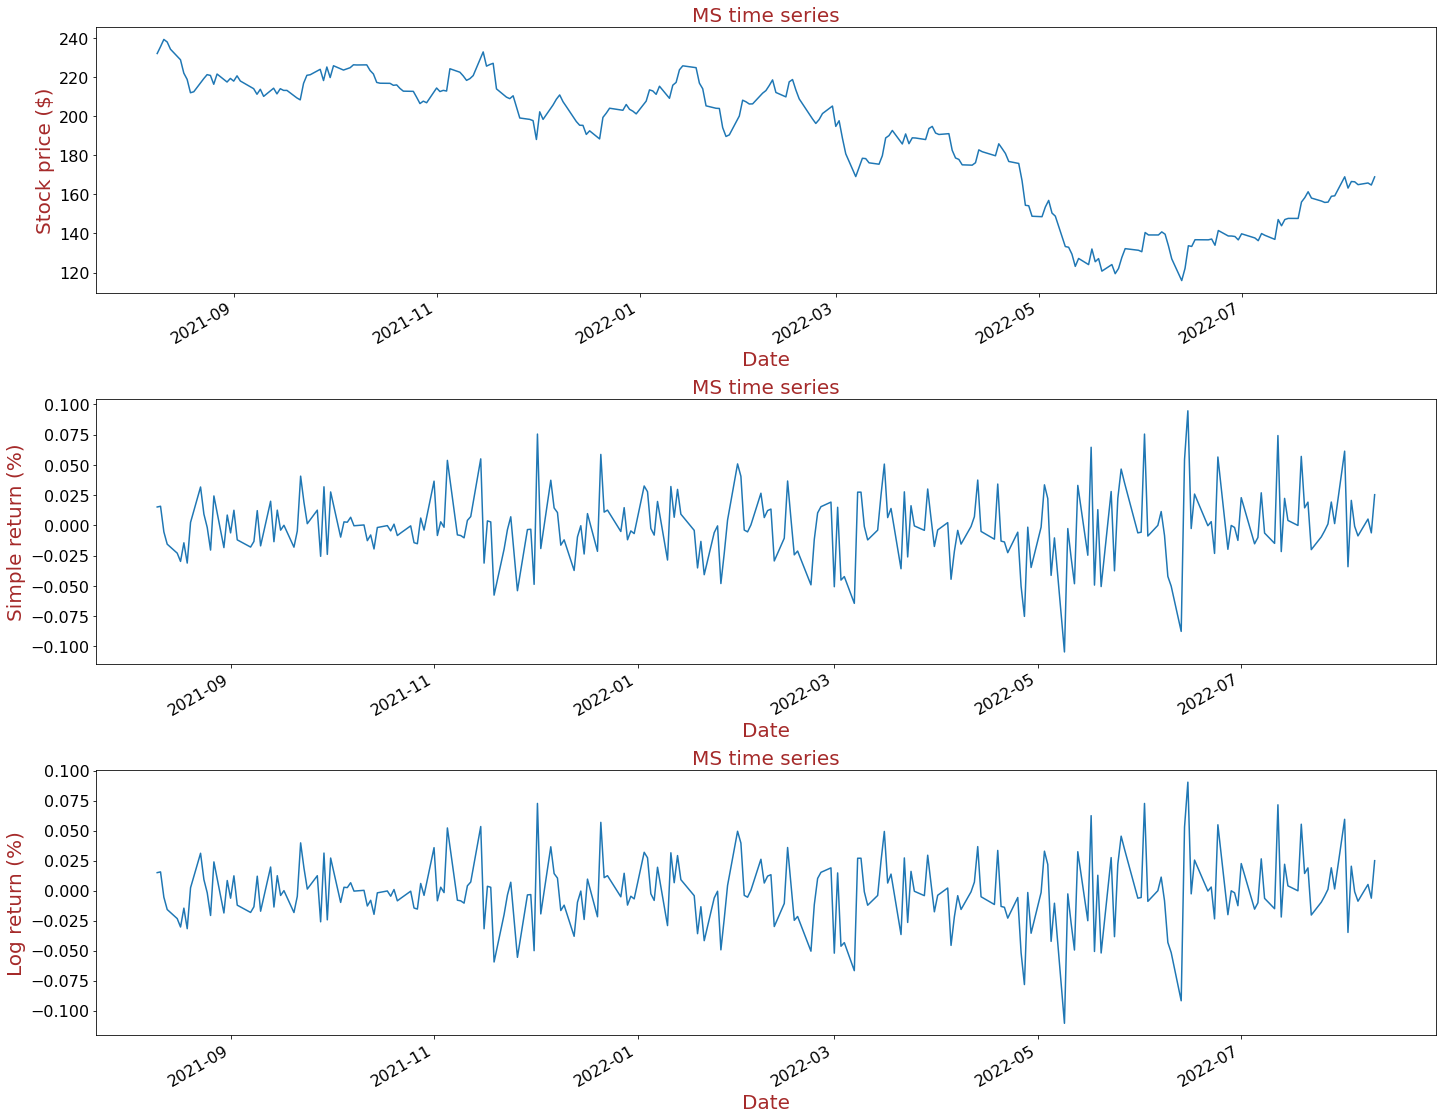

In [5]:
#Following charts present the prices of MS as well as its simple and logarithmic
fig,ax= plt.subplots(3,1 ,figsize=(24,20),sharex=False)
plt.subplots_adjust(bottom=0.1,  top=0.9, hspace=0.4)


df.adj_close.plot(ax=ax[0],fontsize=16)


ax[0].set_title('MS time series',fontsize=20,color='brown')
ax[0].set_ylabel('Stock price ($)',fontsize=20,color='brown')
ax[0].set_xlabel('Date',fontsize=20,color='brown')


df.simple_rtn.plot(ax=ax[1],fontsize=16)

ax[1].set_title('MS time series',fontsize=20,color='brown')
ax[1].set_ylabel('Simple return (%)',fontsize=20,color='brown')
ax[1].set_xlabel('Date',fontsize=20,color='brown')

df.log_rtn.plot(ax=ax[2],fontsize=16)
ax[2].set_title('MS time series',fontsize=20,color='brown')
ax[2].set_ylabel('Log return (%)',fontsize=20,color='brown')
ax[2].set_xlabel('Date',fontsize=20,color='brown')


In [6]:
df_rolling = df[['simple_rtn']].rolling(window=22).aggregate(['mean','std'])


df_rolling.columns = df_rolling.columns.droplevel()
df_outliers = df.join(df_rolling)
def indentify_outliers(row, n_sigmas=3) :
    x = row['simple_rtn']
    mu = row['mean']
    sigma = row['std']
    if (x > mu + 3 * sigma) | (x < mu - 3 * sigma) :
        return 1
    else:
        return 0 


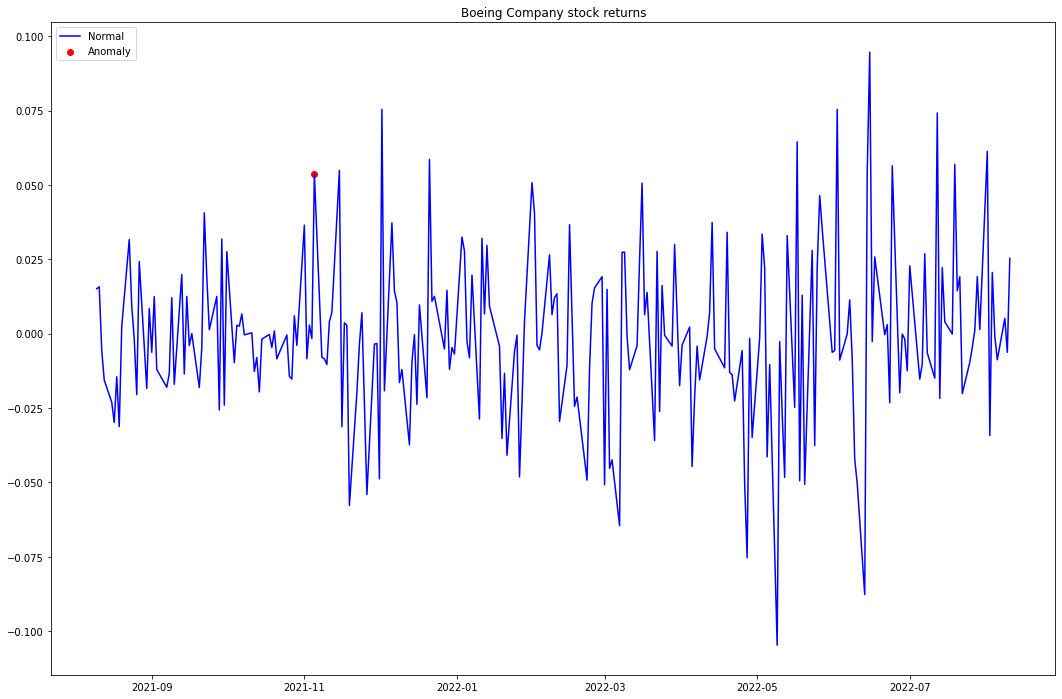

In [7]:
df_outliers['outlier'] = df_outliers.apply(indentify_outliers,axis=1)
outliers = df_outliers.loc[df_outliers['outlier']==1,['simple_rtn']]

fig, ax = plt.subplots(figsize=(18,12))
ax.plot(df_outliers.index,df_outliers.simple_rtn,color='blue',label='Normal')
ax.scatter(outliers.index,outliers.simple_rtn, color='red',label='Anomaly')
ax.set_title("Boeing Company stock returns")
ax.legend(loc='upper left')

In [8]:
class SmaStrategy (bt.Strategy):    #backtrader strategy
    params = (('ma_period', 20), )  #try running for 25, 30, 45,90 and compare profit
    
    def __init__(self):
        self.data_close = self.datas[0].close
        self.order = None
        self.price = None
        self.comm = None
        self.sma = bt.ind.SMA(self.datas[0],period=self.params.ma_period)
        

    def log(self, txt):
        dt=self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price:{order.executed.price:.2f},Cost:{order.executed.value:.2f},Commission:{order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm 
            else:
                self.log(f' SELL EXECUTED --- Price:{order.executed.price:.2f},Cost:{order.executed.value:.2f},Commission:{order.executed.comm:.2f}')        
                self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                    self.log('Order Failed')
        self.order=None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT ---Gross: {trade.pnl:.2f},Net:{trade.pnlcomm:.2f}')

    def next(self):
        if self.order:
            return
        if not self.position:
            if self.data_close[0] > self.sma[0]:
                self.log(f' BUY CREATED --- Price:{self.data_close[0]:.2f}')
                self.order = self.buy()
        else:
            if self.data_close[0] < self.sma[0]:
                    self.log(f' SELL CREATED --- Price:{self.data_close[0]:.2f}')
                    self.order = self.sell()

In [9]:
pip install yfinance


Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install backtesting

Note: you may need to restart the kernel to use updated packages.


In [11]:
import yfinance as yf
import backtrader as bt

cash = 10000000
commission = 0.001
percentageUsed = 10

cerebro = bt.Cerebro(stdstats=False)
data = bt.feeds.PandasData(dataname=yf.download(stock,startdate ,enddate ))
# data = bt.feeds.YahooFinanceData(dataname='GOOG',fromdate=datetime(2021,8,3),todate=datetime(2022,8,4))


[*********************100%***********************]  1 of 1 completed


In [12]:

cerebro.adddata(data)


In [13]:
cerebro.broker.setcash(cash)   #cash value is $10M
cerebro.addstrategy(SmaStrategy)
cerebro.broker.setcommission(commission)
cerebro.addsizer(bt.sizers.PercentSizer,percents=percentageUsed)  # only 10% of our portfolio is used
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

Starting Portfolio Value: 10000000.00
2021-09-22,  BUY CREATED --- Price:216.98
2021-09-23, BUY EXECUTED --- Price:217.81,Cost:1003825.25,Commission:1003.83
2021-10-14,  SELL CREATED --- Price:217.44
2021-10-15,  SELL EXECUTED --- Price:218.17,Cost:1003825.25,Commission:1005.48
2021-10-15, OPERATION RESULT ---Gross: 1659.14,Net:-350.17
2021-11-05,  BUY CREATED --- Price:224.46
2021-11-08, BUY EXECUTED --- Price:225.24,Cost:1003439.86,Commission:1003.44
2021-11-19,  SELL CREATED --- Price:214.13
2021-11-22,  SELL EXECUTED --- Price:215.00,Cost:1003439.86,Commission:957.82
2021-11-22, OPERATION RESULT ---Gross: -45619.03,Net:-47580.29
2021-12-22,  BUY CREATED --- Price:201.69
2021-12-23, BUY EXECUTED --- Price:202.13,Cost:997378.08,Commission:997.38
2022-01-21,  SELL CREATED --- Price:205.44
2022-01-24,  SELL EXECUTED --- Price:199.85,Cost:997378.08,Commission:986.13
2022-01-24, OPERATION RESULT ---Gross: -11250.29,Net:-13233.79
2022-02-07,  BUY CREATED --- Price:211.92
2022-02-08, BUY E

<IPython.core.display.Javascript object>


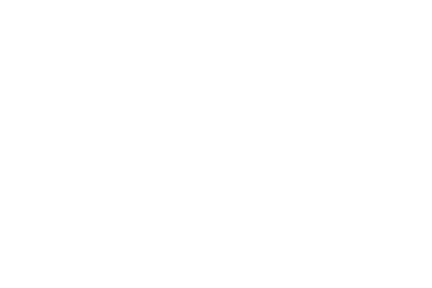

[[<Figure size 432x288 with 3 Axes>]]

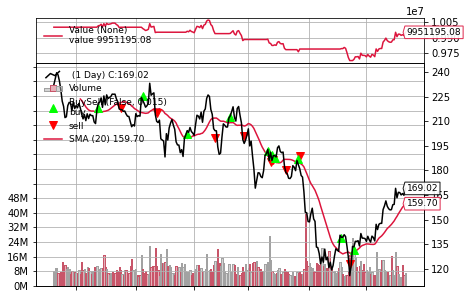

In [14]:
print (f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.broker.getvalue()
cerebro.run()
print(f'Final Portfolio Value:  {cerebro.broker.getvalue():.2f}')
profit = cerebro.broker.getvalue() - cash
print('+'*50)
print(f'Profit value is : {profit:.2f}')
print('+'*50)
cerebro.plot()

#if ImportError Cannot import name warnings from matplotlib.dates
#pip uninstall backtrader
#pip install git+https://github.com/mementum/backtrader.git@0fa63ef4a35dc53cc7320813f8b15480c8f85517


In [15]:
# rerun backtesting without setting any commissions

cerebro = bt.Cerebro(stdstats=False)
data = bt.feeds.PandasData(dataname=yf.download(stock, startdate, enddate))
cerebro.adddata(data)
cerebro.broker.setcash(cash)   #cash value is $10M
cerebro.addstrategy(SmaStrategy)
cerebro.broker.setcommission(0)
cerebro.addsizer(bt.sizers.PercentSizer,percents=10)  # only 10% of our portfolio is used
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)
print (f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.broker.getvalue()
cerebro.run()
print(f'Final Portfolio Value:  {cerebro.broker.getvalue():.2f}')
profitNocomm = cerebro.broker.getvalue() - cash
comm = profitNocomm - profit
print(f'profit without commission is :{profitNocomm:.2f}')
print('+'*50)
print(f'costs of the transactions is  :{comm:.2f}')
print('+'*50)

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 10000000.00
2021-09-22,  BUY CREATED --- Price:216.98
2021-09-23, BUY EXECUTED --- Price:217.81,Cost:1003825.25,Commission:0.00
2021-10-14,  SELL CREATED --- Price:217.44
2021-10-15,  SELL EXECUTED --- Price:218.17,Cost:1003825.25,Commission:0.00
2021-10-15, OPERATION RESULT ---Gross: 1659.14,Net:1659.14
2021-11-05,  BUY CREATED --- Price:224.46
2021-11-08, BUY EXECUTED --- Price:225.24,Cost:1003641.49,Commission:0.00
2021-11-19,  SELL CREATED --- Price:214.13
2021-11-22,  SELL EXECUTED --- Price:215.00,Cost:1003641.49,Commission:0.00
2021-11-22, OPERATION RESULT ---Gross: -45628.19,Net:-45628.19
2021-12-22,  BUY CREATED --- Price:201.69
2021-12-23, BUY EXECUTED --- Price:202.13,Cost:997775.08,Commission:0.00
2022-01-21,  SELL CREATED --- Price:205.44
2022-01-24,  SELL EXECUTED --- Price:199.85,Cost:997775.08,Commission:0.00
2022-01-24, OPERATION RESULT ---Gross: -11254.77,Net:-11254.77
2022-

In [16]:
# pip install fastquant

In [17]:
# from __future__ import (absolute_import,division,print_function,unicode_literals,)

# import backtrader as bt
# from datetime import datetime
# from fastquant.strategies.base import BaseStrategy

# class MACDStrategy(BaseStrategy):
#     params = (("fast_period", 12),("slow_period", 26),("signal_period", 9),)
#     def __init__(self):
#         super().__init__()

#         self.fast_period = self.params. fast_period
#         self.slow_period = self.params.slow_period
#         self.signal_period = self.params.signal_period
#         self.commission = self.params.commission

#         if self.strategy_logging:
#             print("===Strategy level arguments===")
#             print("fast_period :", self.fast_period)
#             print("slow_period :", self.slow_period)
#             print("signal_period :", self.signal_period)

#         macd_ind = bt.ind.MACD(
#         period_mel=self.fast_period,
#         period_me2=self.slow_period,
#         period_signal=self.signal_period,)

#         self.macd = macd_ind.macd
#         self.signal = macd_ind.signal
#         self.crossover = bt.ind.CrossOver(self.macd, self.signal)
        
#     def buy_signal(self):
#         return self.crossover > 0

#     def sell_signal(self):
#         return self.crossover < 0



In [18]:
#MACDStrategy

# cerebro = bt.Cerebro(stdstats=False)
# data = bt.feeds.PandasData(dataname=yf.download(stock, startdate, enddate))
# cerebro.adddata(data)
# cerebro.broker.setcash(cash)   
# cerebro.addstrategy(MACDStrategy)
# cerebro.broker.setcommission(commission)
# cerebro.addsizer(bt.sizers.PercentSizer,percents=10)  
# cerebro.addobserver(bt.observers.BuySell)
# cerebro.addobserver(bt.observers.Value)
# print (f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
# cerebro.broker.getvalue()
# cerebro.run()
# print(f'Final Portfolio Value:  {cerebro.broker.getvalue():.2f}')
# profitNocomm = cerebro.broker.getvalue() - cash
# comm = profitNocomm - profit
# print(f'profit without commission is :{profitNocomm:.2f}')
# print('+'*50)
# print(f'costs of the transactions is  :{comm:.2f}')
# print('+'*50)

# cerebro.plot()

In [19]:
pip install bokeh

Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install echo

Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install backtrader

Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install bt

Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install ffn 

Note: you may need to restart the kernel to use updated packages.


In [24]:
import bt
 # fetch some data
data = bt.get('spy,agg', start='2010-01-01')
data.head()

,spy,agg
Date,,
2010-01-04,89.225388,74.661934
2010-01-05,89.461601,75.001602
2010-01-06,89.524559,74.958298
2010-01-07,89.902489,74.871506
2010-01-08,90.201645,74.914909


In [25]:
import ffn
returns = ffn.get('BA,aapl,msft,TSLA', start='2010-01-01').to_returns().dropna()
returns.calc_mean_var_weights().as_format('.2%')

ba       0.00%
aapl    38.64%
msft    36.48%
tsla    24.87%
dtype: object

In [26]:
# create the strategy
s = bt.Strategy('s1', [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

In [27]:
# create a backtest and run it
test = bt.Backtest(s, data)
res = bt.run(test)

<IPython.core.display.Javascript object>


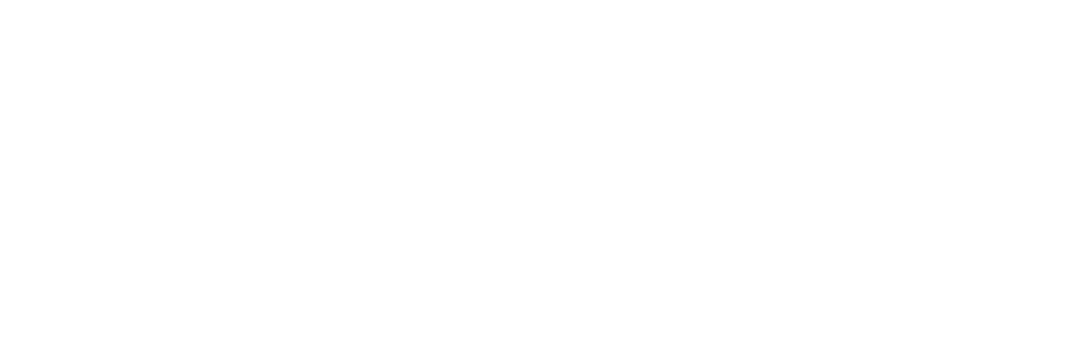

<AxesSubplot:title={'center':'Equity Progression'}>

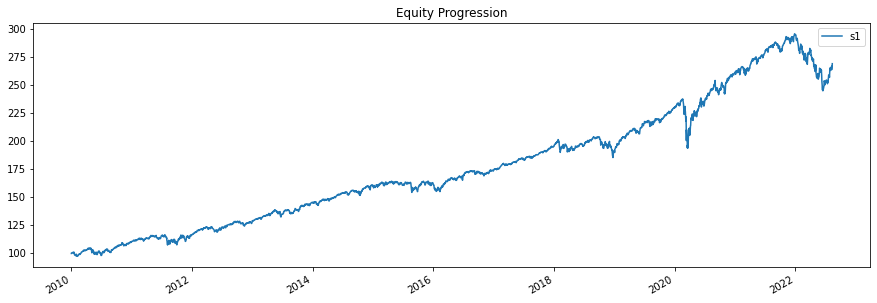

In [28]:
res.plot()

In [29]:
res.display()

Stat                 s1
-------------------  ----------
Start                2010-01-03
End                  2022-08-12
Risk-free rate       0.00%

Total Return         168.80%
Daily Sharpe         0.95
Daily Sortino        1.44
CAGR                 8.16%
Max Drawdown         -18.42%
Calmar Ratio         0.44

MTD                  1.45%
3m                   4.99%
6m                   -3.61%
YTD                  -8.70%
1Y                   -5.53%
3Y (ann.)            7.70%
5Y (ann.)            7.65%
10Y (ann.)           7.91%
Since Incep. (ann.)  8.16%

Daily Sharpe         0.95
Daily Sortino        1.44
Daily Mean (ann.)    8.22%
Daily Vol (ann.)     8.65%
Daily Skew           -0.95
Daily Kurt           16.21
Best Day             4.77%
Worst Day            -6.63%

Monthly Sharpe       1.11
Monthly Sortino      2.04
Monthly Mean (ann.)  8.32%
Monthly Vol (ann.)   7.49%
Monthly Skew         -0.33
Monthly Kurt         1.52
Best Month           7.57%
Worst Month          -6.44%

Yearly Sha

<IPython.core.display.Javascript object>


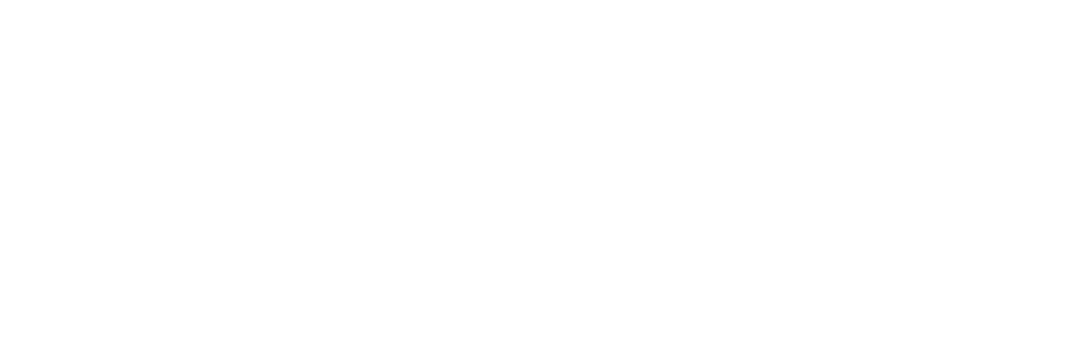

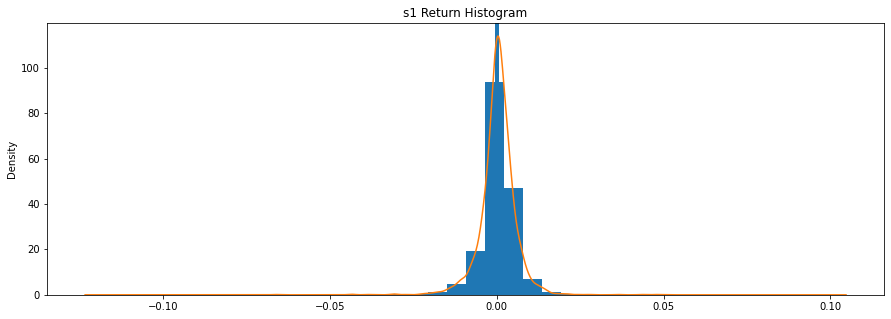

In [30]:
res.plot_histogram()

<IPython.core.display.Javascript object>


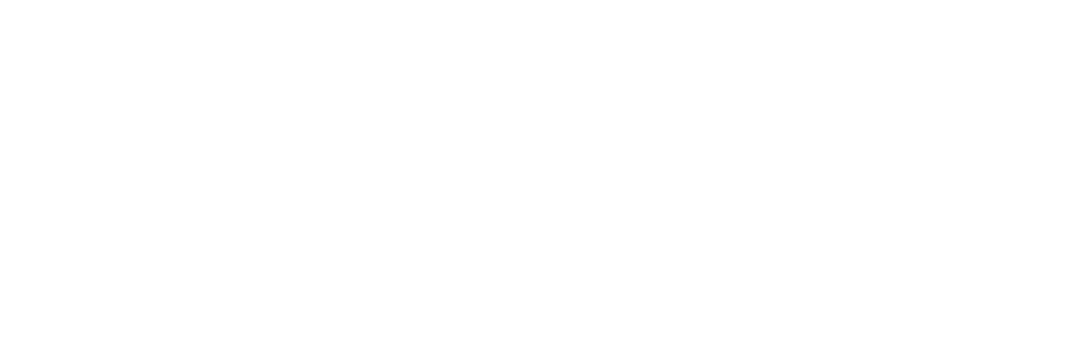

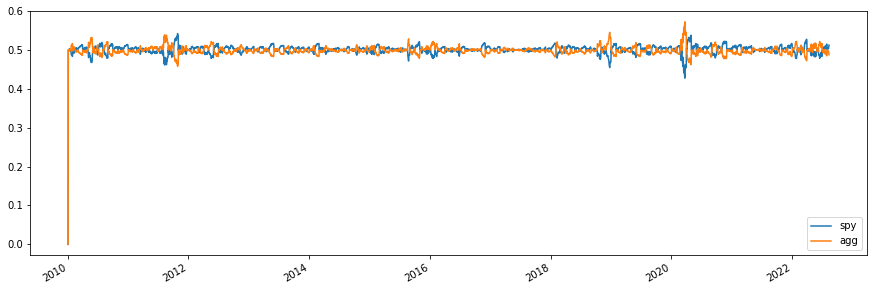

In [31]:
res.plot_security_weights()

In [32]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA


class SmaCross(Strategy):
    n1 = 5
    n2 = 20

    def init(self):
        close = self.data.Close
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()


bt = Backtest(ba, SmaCross,
              cash=cash/10, commission=commission,
              exclusive_orders=True)

output = bt.run()

bt.plot()

C:\Python310\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

Row(id='1450', ...)

In [33]:
pip install ta-lib

Note: you may need to restart the kernel to use updated packages.


In [34]:
import numpy
import talib

close = numpy.random.random(100)

In [35]:
output = talib.SMA(close)

In [36]:
from talib import MA_Type

upper, middle, lower = talib.BBANDS(close, matype=MA_Type.T3)

In [37]:
output = talib.MOM(close, timeperiod=5)

In [38]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
#https://www.newtraderu.com/2022/05/14/moving-average-crossover-backtest-results/#:~:text=How%20do%20you%20do%20a,or%20break%20below%20each%20other.
from backtesting.test import SMA

class SmaCross(Strategy):
    n1 = 5
    n2 = 20

    def init(self):
        close = self.data.Close
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()


bt = Backtest(ba, SmaCross,
              cash=cash/10, commission=commission,
              exclusive_orders=True)



output = bt.run()
bt.plot()

Row(id='2182', ...)

In [39]:


ba.tail()

,Open,High,Low,Close,Adj Close,Volume
2022-08-04,165.770004,168.119995,164.410004,166.500000,166.500000,5039600
2022-08-05,164.399994,167.070007,163.929993,165.039993,165.039993,4699700
2022-08-08,166.410004,171.089996,164.710007,165.889999,165.889999,11293200
2022-08-09,166.509995,166.509995,163.449997,164.850006,164.850006,6064800
2022-08-10,168.350006,171.139999,167.250000,169.020004,169.020004,7181700


In [40]:
import pandas as pd


def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

In [41]:
from backtesting import Strategy
from backtesting.lib import crossover


class SmaCross(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    n1 = 5
    n2 = 20
    
    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()
            
bt = Backtest(ba, SmaCross,
              cash=cash/10, commission=commission,
              exclusive_orders=True)



output = bt.run()
bt.plot()          

Row(id='2914', ...)

In [42]:
from backtesting import Backtest

bt = Backtest(ba, SmaCross, cash=cash/10, commission=commission)
stats = bt.run()
stats

Start                     2021-08-09 00:00:00
End                       2022-08-10 00:00:00
Duration                    366 days 00:00:00
Exposure Time [%]                   86.220472
Equity Final [$]                875320.888777
Equity Peak [$]                 1022411.78026
Return [%]                         -12.467911
Buy & Hold Return [%]              -27.231239
Return (Ann.) [%]                  -12.376082
Volatility (Ann.) [%]               35.665073
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -35.700374
Avg. Drawdown [%]                   -9.077675
Max. Drawdown Duration      287 days 00:00:00
Avg. Drawdown Duration       64 days 00:00:00
# Trades                                   13
Win Rate [%]                        30.769231
Best Trade [%]                      25.480733
Worst Trade [%]                    -12.372301
Avg. Trade [%]                    

In [43]:
bt.plot()

Row(id='3646', ...)

In [44]:
%%time

stats = bt.optimize(n1=range(5, 30, 5),
                    n2=range(10, 70, 5),
                    maximize='Equity Final [$]',
                    constraint=lambda param: param.n1 < param.n2)

CPU times: total: 1.91 s
Wall time: 1.94 s


In [45]:
stats

Start                     2021-08-09 00:00:00
End                       2022-08-10 00:00:00
Duration                    366 days 00:00:00
Exposure Time [%]                   79.527559
Equity Final [$]               1771491.381244
Equity Peak [$]                1779067.234088
Return [%]                          77.149138
Buy & Hold Return [%]              -27.231239
Return (Ann.) [%]                   76.353311
Volatility (Ann.) [%]               59.756109
Sharpe Ratio                         1.277749
Sortino Ratio                        3.903609
Calmar Ratio                         5.055758
Max. Drawdown [%]                  -15.102248
Avg. Drawdown [%]                   -6.094896
Max. Drawdown Duration       68 days 00:00:00
Avg. Drawdown Duration       20 days 00:00:00
# Trades                                    5
Win Rate [%]                            100.0
Best Trade [%]                      31.419805
Worst Trade [%]                      0.394353
Avg. Trade [%]                    

In [46]:
stats._strategy


<Strategy SmaCross(n1=25,n2=50)>

In [47]:
bt.plot(plot_volume=False, plot_pl=False)

Row(id='4255', ...)

In [48]:
stats.tail()

Expectancy [%]                                            12.755675
SQN                                                        2.063777
_strategy                                     SmaCross(n1=25,n2=50)
_equity_curve                       Equity  DrawdownPct Drawdown...
_trades               Size  EntryBar  ExitBar  EntryPrice   Exit...
dtype: object

In [49]:
stats['_equity_curve'] 

,Equity,DrawdownPct,DrawdownDuration
2021-08-09,1.000000e+06,0.000000,NaT
2021-08-10,1.000000e+06,0.000000,NaT
2021-08-11,1.000000e+06,0.000000,NaT
2021-08-12,1.000000e+06,0.000000,NaT
2021-08-13,1.000000e+06,0.000000,NaT
...,...,...,...
2022-08-04,1.752026e+06,0.015200,NaT
2022-08-05,1.736663e+06,0.023835,NaT
2022-08-08,1.745607e+06,0.018808,NaT
2022-08-09,1.734664e+06,0.024959,NaT


In [50]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,4613,52,66,216.756533,219.360001,12009.794798,0.012011,2021-10-21,2021-11-10,20 days
1,-4618,66,117,219.140641,200.100006,87929.650150,0.086888,2021-11-10,2022-01-25,76 days
2,5491,117,139,200.300106,201.089996,4337.287243,0.003944,2022-01-25,2022-02-25,31 days
3,-5496,139,231,200.888906,137.770004,346901.485772,0.314198,2022-02-25,2022-07-11,136 days
4,10522,231,253,137.907774,168.350006,320313.163281,0.220743,2022-07-11,2022-08-10,30 days
